In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import datetime as dt

In [3]:
udf = pd.read_csv('../data/2nd/tianchi_mobile_recommend_train_user_filtered.csv', index_col=['user_id', 'item_id'])
u = udf.reset_index()

## 评估方法定义

In [27]:
def f1(pred, ref):
    pred_len = float(len(pred))
    ref_len = float(len(ref))
    intersected_len = len(pred.intersection(ref))
    precision = intersected_len / pred_len
    recall = intersected_len / ref_len
    f = 2 * precision * recall / float(precision + recall)
    print "F1: {0}, Precision: {1}, Recall: {2}".format(f, precision, recall)
    return f, precision, recall

def evaluate_method(case, date):
    prev_date = (dt.datetime.strptime(date, '%Y-%m-%d') - dt.timedelta(1)).strftime('%Y-%m-%d')
    predict_set = case(udf, prev_date)
    result_set = extract_result_set(udf, date)
    return f1(predict_set, result_set)

def date_range_evaluate_method_plot(case, date1, date2):
    selected_date_range = pd.date_range(date1, date2)
    analysis = pd.DataFrame(
        [list(evaluate_method(case, d.strftime('%Y-%m-%d'))) for d in selected_date_range],
        index=selected_date_range,
        columns=['f1', 'precision', 'recall']
    )
    analysis.plot(kind='bar', figsize=(15, 5))
    return analysis

In [5]:
def extract_label(df, date):
    tlabel = df[(df['date'] == pred_date)].groupby(['user_id', 'item_id']).behavior_type.max()
    return tlabel.map(lambda d: 1 if d == 4 else 0)

In [6]:
def extract_result_set(df, date):
    return set(df[(df.date == date) & (df.behavior_type == 4)].index)

## 方案一

1. 通过“添加购物车”行为筛选买家候选；
2. 过滤当天已经购买的商品；
3. 过滤当天 18 点以后发生购买行为且当天不再购买的用户；

In [7]:
def case1(df, date):
    cart_df = df[(df.date == date) & (df.behavior_type == 3) & (df.hour > 20)]
    buy_df = df[(df.date == date) & (df.behavior_type == 4)]
    
    filter_buy_df = cart_df[~cart_df.index.isin(buy_df.index)]
    
    bought_lt18_set = set(df[(df.date == date) & (df.behavior_type == 4) & (df.hour <= 18)].reset_index().user_id)
    bought_gt18_set = set(df[(df.date == date) & (df.behavior_type == 4) & (df.hour > 18)].reset_index().user_id)
    
    filter_buy_df.reset_index(inplace=True)
    
    return set(filter_buy_df[~filter_buy_df.user_id.isin(bought_lt18_set - bought_gt18_set)].set_index(['user_id', 'item_id']).index)

In [9]:
evaluate_method(case1, '2014-12-18')

(0.04075691411935953, 0.047619047619047616, 0.035623409669211195)

## 方案二

1. 通过“添加购物车”行为筛选买家候选；
2. 过滤当天已经购买的商品；

In [10]:
def case2(df, date):
    cart_df = df[(df.date == date) & (df.behavior_type == 3) & (df.hour > 15)]
    buy_df = df[(df.date == date) & (df.behavior_type == 4)]
    
    filter_buy_df = cart_df[~cart_df.index.isin(buy_df.index)]
    
#     bought_lt18_set = set(df[(df.date == date) & (df.behavior_type == 4) & (df.hour <= 18)].reset_index().user_id)
#     bought_gt18_set = set(df[(df.date == date) & (df.behavior_type == 4) & (df.hour > 18)].reset_index().user_id)
#     filter_buy_df.reset_index(inplace=True)
    
    return set(filter_buy_df.index)

In [13]:
evaluate_method(case2, '2014-12-18')

(0.043650793650793655, 0.03577235772357724, 0.05597964376590331)

## 方案三

1. 通过“添加购物车”行为筛选买家候选；
2. 过滤当天已经购买的商品；
3. 过滤当天发生购买行为的用户（另作考虑）；
4. 从当天发生购买行为的用户中进行规则筛选。

In [16]:
def case3(df, date):
    cart_df = df[(df.date == date) & (df.behavior_type == 3) & (df.hour > 20)]
    
    case1_set = case1(df, date)
    case2_set = case2(df, date)
    remain_set = case2_set - case1_set
    print 'Filtered:', len(remain_set)
    
    features_df = pd.read_csv('../data/new2/apr23_train_%s_2nd_all_2.csv' % date, index_col=['user_id', 'item_id'])
    features_df['user_buy_sum'] = features_df.user_beh4_at1 + features_df.user_beh4_at2 + features_df.user_beh4_at3
    features_df['item_buy_sum'] = features_df.item_beh4_at1 + features_df.item_beh4_at2 + features_df.item_beh4_at3
    
    features_df = pd.merge(features_df.reset_index(), df.reset_index(), on=['user_id', 'item_id'], how='left').set_index(['user_id', 'item_id'])
    
    sel = features_df[features_df.index.isin(remain_set)]
    
    def df18_selu(df):
        n = int(min(math.ceil(df.item_id.nunique() * 0.8), 5))
        del df['user_id']
        del df['item_category']
        return df.groupby(['item_id']).agg(dict(
                last_0_cart='first',
                itemCartToBuyRate1='first',
                itemCartToBuyRate2='first',
                last_0_collect='first',
                last_0_browse_times='first',
                #usercartToBuyRate1='first',
                #usercartToBuyRate2='first',
                last_1_cart='first',
                last_1_collect='first',
                last_1_browse_times='first',
                last_2_collect='first',
                last_2_cart='first',
                last_2_browse_times='first',
                item_beh4_at1='first',
                item_beh4_at2='first',
                item_beh4_at3='first'
            )).sort(['last_0_cart','itemCartToBuyRate1', 'itemCartToBuyRate2',
                     'item_beh4_at1','item_beh4_at2','item_beh4_at3',
                     'last_0_collect','last_0_browse_times',
                     # 'usercartToBuyRate1','usercartToBuyRate2',
                     'last_1_cart','last_1_collect','last_1_browse_times','last_2_cart','last_2_collect',
                     'last_2_browse_times'
                    ], ascending=False).head(n)
    selu = sel.reset_index().groupby(['user_id', 'item_category']).apply(df18_selu)
    if len(selu) > 0:
        uset = set(selu.reset_index().set_index(['user_id', 'item_id']).index)
        print 'Added:', len(uset)

        case3_set = case1_set.copy()

        for it in uset: case3_set.add(it)
        return case3_set
    else:
        return case1_set

In [18]:
evaluate_method(case3, '2014-12-18')

Filtered: 321
Added: 17


(0.03977272727272727, 0.04501607717041801, 0.035623409669211195)

## 方案四

1. 抽取转化率、行为数、首次购买小时数作为特征；
2. 以用户、分类为标准，根据最后购物车行为、购物车到购买几率等特征进行排序，最多取前五个；

In [19]:
def case4(df, date):
    label_date = (dt.datetime.strptime(date, '%Y-%m-%d') + dt.timedelta(1)).strftime('%Y-%m-%d')
    features_df = pd.read_csv('../data/new2/apr23_train_%s_2nd_all_2.csv' % label_date, index_col=['user_id', 'item_id'])
    features_df = pd.merge(features_df.reset_index(),
                           df[['item_category']].reset_index().drop_duplicates(),
                           on=['user_id', 'item_id'], how='left'
                          ).set_index(['user_id', 'item_id'])
    
    sel = features_df[features_df.index.isin(case2(df, date))]
    
    def df18_selu(df):
        n = int(min(math.ceil(df.item_id.nunique() * 0.8), 5))
        del df['user_id']
        del df['item_category']
        return df.groupby(['item_id']).agg(dict(
                last_0_cart='first',
                itemCartToBuyRate1='first',
                itemCartToBuyRate2='first',
                last_0_collect='first',
                last_0_browse_times='first',
                #usercartToBuyRate1='first',
                #usercartToBuyRate2='first',
                last_1_cart='first',
                last_1_collect='first',
                last_1_browse_times='first',
                last_2_collect='first',
                last_2_cart='first',
                last_2_browse_times='first',
                item_beh4_at1='first',
                item_beh4_at2='first',
                item_beh4_at3='first'
            )).sort(['last_0_cart','itemCartToBuyRate1', 'itemCartToBuyRate2',
                     'item_beh4_at1','item_beh4_at2','item_beh4_at3',
                     'last_0_collect','last_0_browse_times',
                     # 'usercartToBuyRate1','usercartToBuyRate2',
                     'last_1_cart','last_1_collect','last_1_browse_times','last_2_cart','last_2_collect',
                     'last_2_browse_times'
                    ], ascending=False).head(n)
    selu = sel.reset_index().groupby(['user_id', 'item_category']).apply(df18_selu)
    
    rset = set(selu.reset_index().set_index(['user_id', 'item_id']).index)

    return rset

In [37]:
evaluate_method(case4, '2014-12-16')

F1: 0.0490928495197, Precision: 0.0467479674797, Recall: 0.0516853932584


(0.04909284951974386, 0.046747967479674794, 0.051685393258426963)

## 方案五

In [32]:
def case5(df, date):
    label_date = (dt.datetime.strptime(date, '%Y-%m-%d') + dt.timedelta(1)).strftime('%Y-%m-%d')
    features_df = pd.read_csv('../data/new2/apr23_train_%s_2nd_all_2.csv' % label_date, index_col=['user_id', 'item_id'])
    features_df = pd.merge(features_df.reset_index(),
                           df[['item_category']].reset_index().drop_duplicates(),
                           on=['user_id', 'item_id'], how='left'
                          ).set_index(['user_id', 'item_id'])
    
    sel = features_df[features_df.index.isin(case2(df, date))]
    
    def df18_selu(df):
        n = int(min(math.ceil(df.item_id.nunique() * 0.8), 5))
        del df['user_id']
        del df['item_category']
        return df.groupby(['item_id']).agg(dict(
                last_0_cart='first',
                itemCartToBuyRate1='first',
                itemCartToBuyRate2='first',
                last_0_collect='first',
                last_0_browse_times='first',
                usercartToBuyRate1='first',
                usercartToBuyRate2='first',
                last_1_cart='first',
                last_1_collect='first',
                last_1_browse_times='first',
                last_2_collect='first',
                last_2_cart='first',
                last_2_browse_times='first',
                item_beh4_at1='first',
                item_beh4_at2='first',
                item_beh4_at3='first'
            )).sort(['last_0_cart','itemCartToBuyRate1', 'itemCartToBuyRate2',
                     'item_beh4_at1','item_beh4_at2','item_beh4_at3',
                     'last_0_collect','last_0_browse_times',
#                      'usercartToBuyRate1','usercartToBuyRate2',
                     'last_1_cart','last_1_collect','last_1_browse_times','last_2_cart','last_2_collect',
                     'last_2_browse_times'
                    ], ascending=False).head(n)
    selu = sel.reset_index().groupby(['user_id', 'item_category']).apply(df18_selu)
    
    topk = int(len(selu) * 0.9)
    selui = selu.reset_index().sort(['usercartToBuyRate1'], ascending=False).head(topk)
    
    rset1 = set(selu.reset_index().set_index(['user_id', 'item_id']).index)
    rset = set(selui.set_index(['user_id', 'item_id']).index)
#     print rset1 - rset

    return rset

In [33]:
evaluate_method(case5, '2014-12-18')

F1: 0.0401337792642, Precision: 0.0357142857143, Recall: 0.0458015267176


(0.04013377926421404, 0.03571428571428571, 0.04580152671755725)

## 方案六

从[方案四](#方案四)的思路出发，使用 Logistic Regression 进行学习并分类。

In [207]:
def case6(date):
    datetime = dt.datetime.strptime(date, '%Y-%m-%d')
    features_df = pd.read_csv('../data/new2/apr23_train_%s_2nd_all_2.csv' % date, index_col=['user_id', 'item_id'])
    
    features = [
        'last_0_cart',
#       'last_0_collect',
        'itemCartToBuyRate1',
        'itemCartToBuyRate2',
        'item_beh4_at1',
#       'item_beh4_at2',
#       'item_beh4_at3',
#       'last_0_collect',
#       'last_0_browse_times',
        'usercartToBuyRate1',
        'usercartToBuyRate2',
        'last_1_cart',
        'last_1_collect',
#       'last_1_browse_times','last_2_cart','last_2_collect',
#       'last_2_browse_times'
    ]
    
    from sklearn import linear_model
    model = linear_model.LogisticRegression(class_weight={1: 50, 0: 1}, C=0.1, multi_class='ovr')
    model.fit(features_df[features].values,
              features_df.cla.values)
    
    def result_set(df, label_date):
        features_df = pd.read_csv('../data/new2/apr23_train_%s_2nd_all_2.csv' % label_date, index_col=['user_id', 'item_id'])
        train_data = features_df[features].values
        ret = model.predict(train_data)
        return set(features_df[ret == 1].index)
    
    return result_set

In [208]:
evaluate_method(case6('2014-12-04'), '2014-12-05')

(0.008605851979345954, 0.0058823529411764705, 0.016025641025641024)

In [196]:
evaluate_method(case4, '2014-12-12')

(0.12388001558239188, 0.17282608695652174, 0.0965391621129326)

## 方案七

In [ ]:
def case7():
    pass

In [71]:
features_df = pd.read_csv('../data/new2/apr23_train_2014-12-04_2nd_all_2.csv')

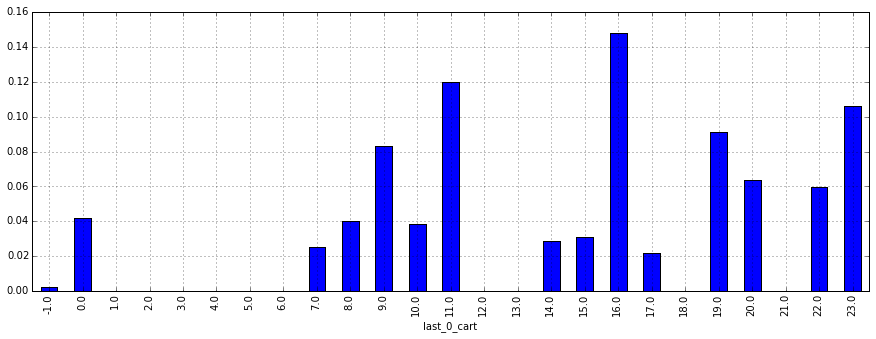

In [221]:
features_df = pd.read_csv('../data/new2/apr23_train_2014-12-06_2nd_all_2.csv')
def user_item_count(df):
    return len(df[df.cla==1][['user_id', 'item_id']].drop_duplicates()) / float(len(df[['user_id', 'item_id']].drop_duplicates()))
g1 = features_df.groupby('last_0_cart').apply(user_item_count)
g1.plot(kind='bar', figsize=(15, 5));

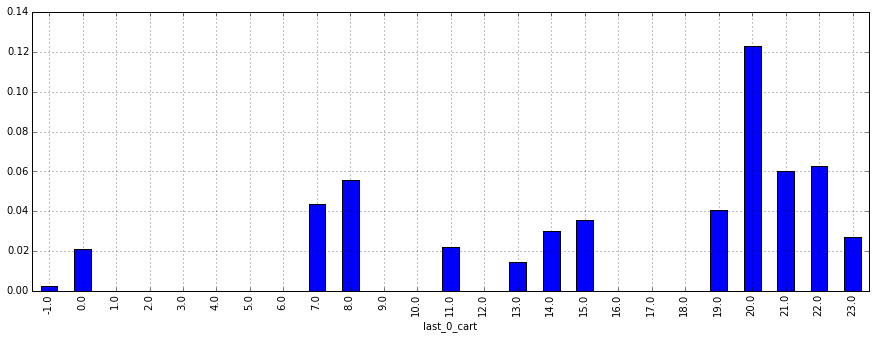

In [223]:
features_df = pd.read_csv('../data/new2/apr23_train_2014-12-16_2nd_all_2.csv')
def user_item_count(df):
    return len(df[df.cla==1][['user_id', 'item_id']].drop_duplicates()) / float(len(df[['user_id', 'item_id']].drop_duplicates()))
g1 = features_df.groupby('last_0_cart').apply(user_item_count)
g1.plot(kind='bar', figsize=(15, 5));

In [183]:
from sklearn import linear_model, svm

In [ ]:
linear_model.LogisticRegression()

In [ ]:
def relative_time(df):
    a = df.sort(['date', 'hour'], asscending=False)
    ret = dict(cart2buy=0, mark2buy=0)
    for i, row in a.iterrows():
        row.
    return pd.Series(ret)
u.groupby(['user_id', 'item_id']).apply()